## **Anggota Kelompok**
1. Adrian Veda Darmawan (24083010090)
2. Khairunisa Olive Ektha (24083010120)
3. Alysha Khanza Dwi Avianti (24083010123)

# Deskripsi dataset

- Dataset yang digunakan dalam analisis ini adalah **“Hourly Electricity Consumption and Production”** yang tersedia di Kaggle dengan tautan: https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production.
- Dataset tersebut berisi data konsumsi dan produksi listrik per jam di Rumania selama kurang lebih 6,5 tahun, yaitu dari 1 Januari 2019 hingga 19 Maret 2025. Konsumsi listrik direpresentasikan oleh kolom `Consumption`, sedangkan produksi total direpresentasikan oleh kolom `Production`.
- Selain produksi total, dataset juga menyediakan pemecahan produksi berdasarkan jenis pembangkit, yaitu `Nuclear`, `Wind`, `Hydroelectric`, `Oil and Gas`, `Coal`, `Solar`, dan `Biomass`, sehingga memungkinkan analisis kontribusi tiap sumber energi terhadap total produksi listrik maupun terhadap keseimbangan produksi–konsumsi.

### Tujuan analisis

Analisis ini bertujuan untuk:
- Menghitung total energi konsumsi dan produksi listrik serta surplus dan defisit daya menggunakan metode integral numerik (metode trapesium) pada data konsumsi–produksi per jam.
- Menggambarkan pola produksi listrik per sumber energi dan konsumsi total melalui visualisasi stacked area dan stacked bar.
- Mengidentifikasi pola harian, termasuk jam dengan konsumsi rata-rata tertinggi (beban puncak) dan jam dengan surplus produksi rata-rata tertinggi dalam satu siklus 24 jam.

> Berdasarkan deskripsi resmi di Kaggle, seluruh nilai konsumsi dan produksi listrik pada dataset ini dinyatakan dalam satuan daya **MW** (megawatt). Karena data dicatat per jam, hasil integral numerik terhadap waktu (dengan $\Delta t = 1$ jam) dapat diinterpretasikan sebagai total energi dalam satuan **MWh** (megawatt-hour). Dengan demikian, nilai total energi konsumsi, produksi, surplus, dan defisit yang diperoleh pada analisis ini menyatakan estimasi energi kumulatif dalam satuan MWh sepanjang periode 2019–2025.



# Setup Pustaka

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import trapezoid

plt.style.use("seaborn-v0_8")
sns.set_palette("tab10")

- Mengimpor pustaka `pandas` dan `numpy` untuk pengolahan data dan komputasi numerik.
- Mengimpor `matplotlib.pyplot` dan `seaborn` untuk membuat visualisasi data (termasuk grafik deret waktu dan stacked chart).
- Mengimpor fungsi `trapezoid` dari `scipy.integrate` untuk menghitung integral numerik dengan metode trapesium pada data konsumsi dan produksi listrik per jam.
- Mengimpor `kagglehub` dan `os` untuk mengunduh dan mengakses dataset langsung dari Kaggle sehingga analisis dapat dijalankan tanpa unggah berkas manual.
- Mengatur gaya visualisasi dengan `seaborn` agar tampilan grafik konsisten dan mudah dibaca.

# Pengambilan dataset dari Kaggle

In [2]:
!pip -q install kagglehub

path = kagglehub.dataset_download(
    "stefancomanita/hourly-electricity-consumption-and-production"
)
print("Folder dataset:", path)
print("Daftar file:", os.listdir(path))

Using Colab cache for faster access to the 'hourly-electricity-consumption-and-production' dataset.
Folder dataset: /kaggle/input/hourly-electricity-consumption-and-production
Daftar file: ['electricityConsumptionAndProductioction.csv']


- Menginstal pustaka `kagglehub` (jika belum tersedia di lingkungan eksekusi) untuk memudahkan proses pengunduhan dataset dari Kaggle.
- Menggunakan fungsi `kagglehub.dataset_download("stefancomanita/hourly-electricity-consumption-and-production")` untuk mengunduh dataset *Hourly Electricity Consumption and Production* dan mendapatkan lokasi folder penyimpanannya.
- Mencetak lokasi folder dataset (`Folder dataset`) dan daftar berkas di dalamnya (`Daftar file`) sebagai verifikasi bahwa proses unduh berhasil dan berkas CSV telah tersedia untuk dibaca pada langkah berikutnya.

In [3]:
df = pd.read_csv(f'{path}/electricityConsumptionAndProductioction.csv')
df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
54165,2025-03-19 19:00:00,8027,6177,1367,593,1922,1217,978,0,71
54166,2025-03-19 20:00:00,7939,6228,1376,647,1920,1223,965,0,71
54167,2025-03-19 21:00:00,7553,6120,1376,671,1881,1171,949,0,69
54168,2025-03-19 22:00:00,6921,6000,1376,730,1827,1130,869,0,69


- Dataset berisi 54.170 baris dan 10 kolom yang mempresentasikan pengamatan konsumsi dan produksi listrik per jam.
- Kolom `DateTime` berisi penanda waktu dengan interval 1 jam dari 1 Januari 2019 hingga 19 Maret 2025, sedangkan kolom `Consumption` dan `Production` masing-masing merepresentasikan konsumsi dan produksi listrik total pada setiap jam.
- Tujuh kolom lainnya (Nuclear, Wind, Hydroelectric, Oil and Gas, Coal, Solar, dan Biomass) merepresentasikan komponen produksi listrik berdasarkan jenis sumber energi yang berkontribusi terhadap nilai `Production` total pada setiap waktu pengamatan.

In [4]:
print(df.columns)
print(df.info())

Index(['DateTime', 'Consumption', 'Production', 'Nuclear', 'Wind',
       'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54170 entries, 0 to 54169
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       54170 non-null  object
 1   Consumption    54170 non-null  int64 
 2   Production     54170 non-null  int64 
 3   Nuclear        54170 non-null  int64 
 4   Wind           54170 non-null  int64 
 5   Hydroelectric  54170 non-null  int64 
 6   Oil and Gas    54170 non-null  int64 
 7   Coal           54170 non-null  int64 
 8   Solar          54170 non-null  int64 
 9   Biomass        54170 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 4.1+ MB
None


- Menggunakan `df.info()` untuk memeriksa struktur data secara lebih rinci; hasilnya menunjukkan bahwa dataset terdiri atas 54.170 entri dengan 10 kolom, tanpa nilai hilang (Non-Null Count = 54.170 untuk seluruh kolom).
- Informasi tipe data memperlihatkan bahwa kolom `DateTime` masih bertipe `object` (string) sehingga perlu dikonversi ke tipe `datetime`, sedangkan sembilan kolom lainnya (`Consumption`, `Production`, dan tujuh komponen produksi) bertipe `int64`, yang sesuai untuk keperluan perhitungan numerik dan analisis integral.

# Pra-pemrosesan kolom waktu

In [5]:
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values("DateTime")
df = df.set_index("DateTime")

- Mengonversi kolom `DateTime` dari tipe `object` (string) menjadi tipe `datetime` dengan fungsi `pd.to_datetime` agar dapat diperlakukan sebagai variabel waktu dalam analisis deret waktu dan agregasi berbasis tanggal/jam.
- Mengurutkan baris data berdasarkan kolom `DateTime` menggunakan `df.sort_values("DateTime")` untuk memastikan urutan pengamatan mengikuti kronologi waktu dari awal sampai akhir periode pengamatan.
- Menjadikan `DateTime` sebagai indeks DataFrame melalui `df.set_index("DateTime")`, sehingga memudahkan operasi berbasis waktu seperti resampling, pengelompokan per jam/hari/bulan, serta integrasi numerik terhadap deret waktu konsumsi dan produksi listrik.

# Definisi kolom utama dan selisih produksi–konsumsi

In [6]:
cons_col = "Consumption"
prod_total_col = "Production"
prod_cols = ["Nuclear", "Wind", "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"]

df["Production_sum_sources"] = df[prod_cols].sum(axis=1)
print((df[prod_total_col] - df["Production_sum_sources"]).describe())

df["Diff_prod_cons"] = df[prod_total_col] - df[cons_col]
print(df[[cons_col, prod_total_col, "Diff_prod_cons"]].head())

count    54170.000000
mean         1.240318
std         24.745932
min       -694.000000
25%          0.000000
50%          1.000000
75%          2.000000
max        821.000000
dtype: float64
                     Consumption  Production  Diff_prod_cons
DateTime                                                    
2019-01-01 00:00:00         6352        6527             175
2019-01-01 01:00:00         6116        5701            -415
2019-01-01 02:00:00         5873        5676            -197
2019-01-01 03:00:00         5682        5603             -79
2019-01-01 04:00:00         5557        5454            -103


- Mendefinisikan nama kolom utama yang digunakan dalam analisis, yaitu `cons_col = "Consumption"` sebagai variabel konsumsi listrik total, `prod_total_col = "Production"` sebagai variabel produksi listrik total, dan `prod_cols` sebagai daftar kolom yang merepresentasikan komponen produksi berdasarkan jenis pembangkit (Nuclear, Wind, Hydroelectric, Oil and Gas, Coal, Solar, dan Biomass).
- Menambahkan kolom `Production_sum_sources` yang berisi jumlah produksi dari seluruh sumber energi pada setiap jam dengan menjumlahkan kolom-kolom di dalam `prod_cols`, kemudian membandingkannya dengan kolom `Production` melalui `(df[prod_total_col] - df["Production_sum_sources"]).describe()` untuk memeriksa konsistensi data.
- Hasil ringkasan selisih `Production - Production_sum_sources` menunjukkan nilai rataan yang sangat kecil (sekitar 1,24) dengan simpangan baku sekitar 24,75 dan sebaran selisih yang relatif dekat dengan nol, sehingga secara umum dapat disimpulkan bahwa kolom `Production` konsisten dengan penjumlahan komponen produksinya dan hanya mengandung deviasi kecil yang dapat dianggap sebagai efek pembulatan atau ketidaktepatan minor.
- Menambahkan kolom `Diff_prod_cons` yang didefinisikan sebagai selisih antara produksi dan konsumsi (`Production - Consumption`) pada setiap jam, sehingga kolom ini dapat diinterpretasikan sebagai indikator surplus (nilai positif) atau defisit (nilai negatif) daya listrik per jam, yang terkait dengan rugi daya atau kebutuhan suplai tambahan.
- Menampilkan beberapa baris pertama dari kolom `Consumption`, `Production`, dan `Diff_prod_cons` untuk mengilustrasikan bahwa, misalnya pada waktu `2019-01-01 00:00:00`, terdapat surplus produksi sebesar 175 unit, sedangkan pada beberapa jam berikutnya terjadi defisit produksi (nilai `Diff_prod_cons` negatif), yang menunjukkan dinamika keseimbangan antara produksi dan konsumsi listrik dari waktu ke waktu.
- Ketika `Production` lebih besar daripada `Consumption`, sistem berada dalam kondisi surplus dan secara praktis dapat diartikan sebagai ekspor energi listrik. Sebaliknya, ketika `Production` lebih kecil daripada `Consumption`, sistem berada dalam kondisi defisit yang mengindikasikan kebutuhan impor energi atau penggunaan sumber cadangan.

# Perhitungan integral numerik (total energi)


### Konsep integral numerik yang digunakan

- Secara teoritis, total energi listrik \(E\) yang dikonsumsi atau diproduksi sepanjang interval waktu tertentu dapat dinyatakan sebagai integral daya terhadap waktu:
  $$E = \int P(t) \, dt$$
- Karena data yang digunakan berbentuk diskrit per jam, integral tersebut didekati secara numerik sebagai penjumlahan:
  $$E \approx \sum_{i=1}^{n} P_i \Delta t$$
  dengan $P_i$ menyatakan daya pada jam ke-$i$ dan $\Delta t = 1$ jam.
- Pada implementasi ini, aproksimasi integral dilakukan menggunakan metode trapesium melalui fungsi `scipy.integrate.trapezoid`, sehingga perhitungan total energi konsumsi, produksi, surplus, dan per sumber dapat dipandang sebagai estimasi luas di bawah kurva daya terhadap waktu.

In [7]:
dt = 1.0
n = len(df)
t_hours = np.arange(n) * dt

def energy_trapz(series, t):
    return trapezoid(series.values, t)

E_cons_total = energy_trapz(df[cons_col], t_hours)
E_prod_total = energy_trapz(df[prod_total_col], t_hours)

E_surplus = energy_trapz(df["Diff_prod_cons"].clip(lower=0), t_hours)
E_deficit = energy_trapz((-df["Diff_prod_cons"]).clip(lower=0), t_hours)

print(f"Total energi konsumsi (approx integral): {E_cons_total:.2f}")
print(f"Total energi produksi  (approx integral): {E_prod_total:.2f}")
print(f"Total energi surplus   (Production > Consumption): {E_surplus:.2f}")
print(f"Total energi defisit   (Consumption > Production): {E_deficit:.2f}")

E_sources = {col: energy_trapz(df[col], t_hours) for col in prod_cols}
print("\nTotal energi per sumber produksi:")
for k, v in E_sources.items():
    print(f"{k}: {v:.2f}")

Total energi konsumsi (approx integral): 353532173.00
Total energi produksi  (approx integral): 345608219.50
Total energi surplus   (Production > Consumption): 14253332.50
Total energi defisit   (Consumption > Production): 22177286.00

Total energi per sumber produksi:
Nuclear: 69470573.50
Wind: 41804094.50
Hydroelectric: 97105831.50
Oil and Gas: 63206392.00
Coal: 61671293.00
Solar: 9306860.00
Biomass: 2975987.50


- Mengasumsikan setiap baris data merepresentasikan interval waktu 1 jam, sehingga sumbu waktu `t_hours` dibentuk sebagai deret 0, 1, 2, …, \(n-1\) dengan \(\Delta t = 1\) jam.
- Mendefinisikan fungsi `energy_trapz` yang menghitung aproksimasi integral numerik suatu deret waktu menggunakan metode trapesium (`scipy.integrate.trapezoid`), yang dalam konteks ini merepresentasikan total energi (akumulasi daya per jam) sepanjang periode pengamatan.
- Menghitung total energi konsumsi (`E_cons_total`) dan total energi produksi (`E_prod_total`) sebagai integral numerik dari kolom `Consumption` dan `Production` terhadap waktu; hasilnya masing-masing sekitar 353,53 juta dan 345,61 juta (dalam satuan energi yang sebanding dengan kWh bila data daya dinyatakan dalam kW).
- Menghitung total energi surplus (`E_surplus`) dengan mengintegralkan hanya selisih positif `Diff_prod_cons` (jam ketika produksi melebihi konsumsi) dan total energi defisit (`E_deficit`) dengan mengintegralkan hanya selisih negatif (dikonversi menjadi positif), yaitu sekitar 14,25 juta untuk surplus dan 22,18 juta untuk defisit.
- Menghitung total energi yang dihasilkan oleh masing-masing sumber pembangkit (Nuclear, Wind, Hydroelectric, Oil and Gas, Coal, Solar, dan Biomass) menggunakan fungsi yang sama, sehingga diperoleh kontribusi kumulatif per sumber selama seluruh periode data (misalnya, sekitar 97,11 juta dari pembangkit hidro dan 69,47 juta dari pembangkit nuklir), yang dapat digunakan untuk membandingkan peran relatif tiap jenis pembangkitan.

In [8]:
summary_energy = pd.DataFrame({
    "Energi": {
        "Total konsumsi": E_cons_total,
        "Total produksi": E_prod_total,
        "Surplus (E_surplus)": E_surplus,
        "Defisit (E_deficit)": E_deficit,
        **E_sources
    }
})
summary_energy

,Energi
Total konsumsi,353532173.0
Total produksi,345608219.5
Surplus (E_surplus),14253332.5
Defisit (E_deficit),22177286.0
Nuclear,69470573.5
Wind,41804094.5
Hydroelectric,97105831.5
Oil and Gas,63206392.0
Coal,61671293.0
Solar,9306860.0


### Ringkasan total energi konsumsi, produksi, surplus, defisit, dan per sumber

- Tabel ringkas ini merangkum hasil perhitungan integral numerik berupa total energi konsumsi, total energi produksi, energi surplus, energi defisit, serta total energi yang dihasilkan oleh masing-masing sumber pembangkit selama periode 2019–2025.
- Nilai total konsumsi dan total produksi masing-masing sekitar 3,54×10^8 dan 3,46×10^8 satuan energi, sedangkan energi surplus dan energi defisit tercatat sekitar 1,43×10^7 dan 2,22×10^7 satuan, yang menunjukkan bahwa secara kumulatif defisit energi lebih besar daripada surplus.
- Kontribusi per sumber menunjukkan bahwa pembangkit Hydroelectric, Nuclear, Oil and Gas, dan Coal merupakan penyumbang energi terbesar, sementara Solar dan Biomass memiliki kontribusi kumulatif yang relatif lebih kecil terhadap total produksi selama horizon waktu pengamatan.

# Stacked Chart Produksi vs Konsumsi

### Visualisasi produksi per sumber dan konsumsi (30 hari pertama)

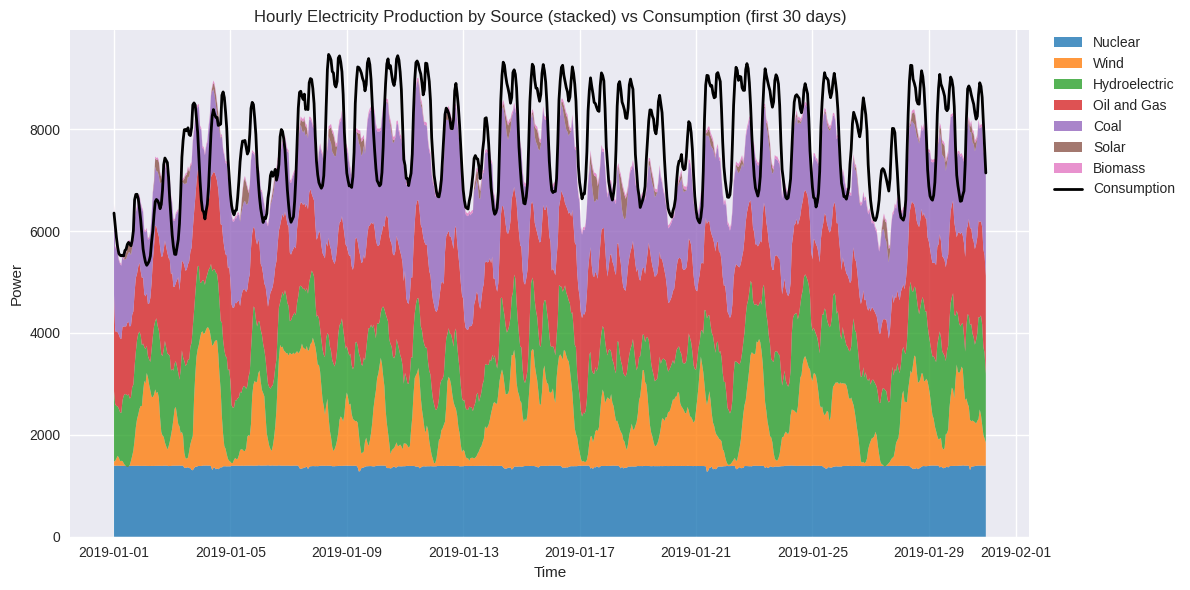

In [9]:
df_sample = df.iloc[:24*30]

plt.figure(figsize=(12, 6))

plt.stackplot(
    df_sample.index,
    [df_sample[col] for col in prod_cols],
    labels=prod_cols,
    alpha=0.8
)

plt.plot(
    df_sample.index,
    df_sample[cons_col],
    color="black",
    linewidth=2,
    label="Consumption"
)

plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0., ncol=1)
plt.ylabel("Power")
plt.xlabel("Time")
plt.title("Hourly Electricity Production by Source (stacked) vs Consumption (first 30 days)")
plt.tight_layout()
plt.show()

- Membuat grafik area bertumpuk (stacked area chart) untuk menggambarkan produksi listrik per sumber energi selama 30 hari pertama periode pengamatan. Setiap komponen produksi (`Nuclear`, `Wind`, `Hydroelectric`, `Oil and Gas`, `Coal`, `Solar`, dan `Biomass`) diplot sebagai lapisan area berwarna yang saling menumpuk terhadap sumbu waktu.
- Di atas area produksi tersebut ditambahkan garis `Consumption` berwarna hitam sebagai representasi konsumsi listrik total per jam. Kombinasi grafik area dan garis ini memungkinkan pengamatan visual mengenai kesesuaian antara total produksi dan konsumsi, serta periode-periode ketika konsumsi berada di atas atau di bawah kapasitas produksi.
- Rentang waktu dibatasi pada 30 hari pertama agar pola harian dan variasi antar sumber energi lebih mudah diamati, tanpa mengurangi karakteristik utama dinamika sistem kelistrikan pada awal periode data.
- Dari visualisasi ini terlihat bahwa pola produksi dan konsumsi menunjukkan fluktuasi harian yang cukup jelas, dengan konsumsi dan produksi cenderung lebih rendah pada malam hingga dini hari dan meningkat pada siang hingga malam hari. Secara umum, area total produksi berada dekat dengan atau sedikit di bawah garis konsumsi pada sejumlah interval, yang mengindikasikan bahwa keseimbangan antara produksi dan konsumsi pada awal periode data berada dekat kapasitas sistem, dengan kontribusi terbesar berasal dari pembangkit hidro, batu bara, dan minyak dan gas.

### Rata-rata produksi per sumber dan konsumsi menurut jam dalam sehari

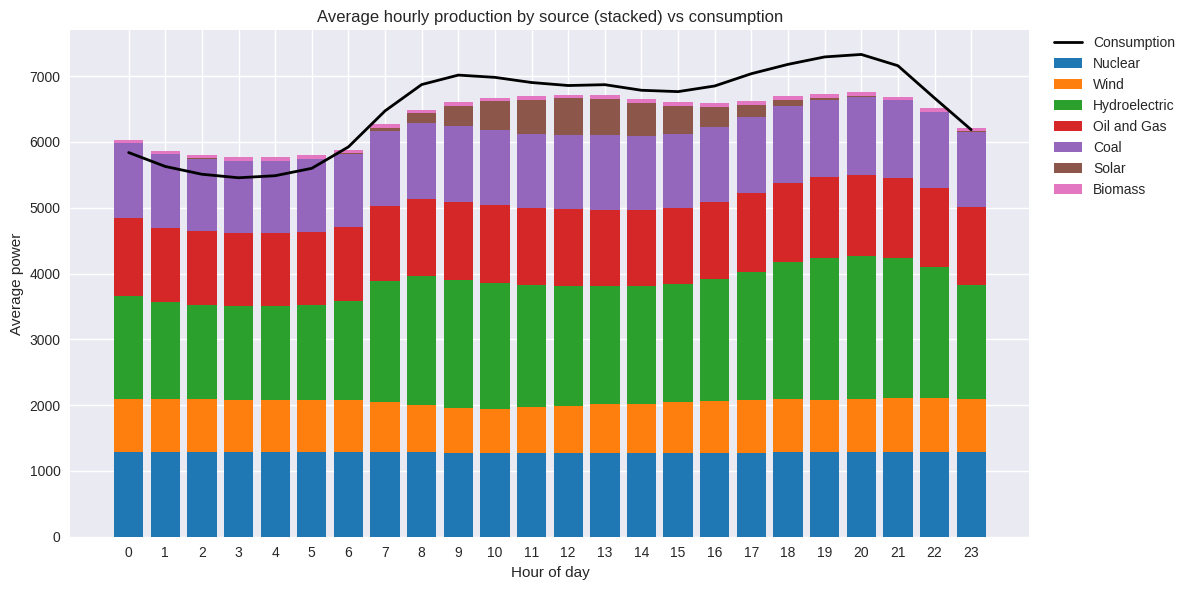

In [10]:
df["hour"] = df.index.hour

mean_by_hour = df.groupby("hour")[prod_cols + [cons_col, prod_total_col, "Diff_prod_cons"]].mean()

plt.figure(figsize=(12, 6))

bottom = np.zeros(len(mean_by_hour))
for col in prod_cols:
    plt.bar(mean_by_hour.index, mean_by_hour[col], bottom=bottom, label=col)
    bottom += mean_by_hour[col].values

plt.plot(
    mean_by_hour.index,
    mean_by_hour[cons_col],
    color="black",
    linewidth=2,
    label="Consumption"
)

plt.xlabel("Hour of day")
plt.ylabel("Average power")
plt.title("Average hourly production by source (stacked) vs consumption")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0., ncol=1)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

- Melakukan agregasi data berdasarkan jam dalam sehari dengan menambahkan kolom `hour = df.index.hour` dan menghitung nilai rata-rata tiap variabel untuk setiap jam 0–23 menggunakan `groupby("hour").mean()`. Hasil agregasi ini merepresentasikan pola rata-rata harian konsumsi dan produksi listrik selama seluruh periode pengamatan.
- Nilai rata-rata produksi per sumber energi (`Nuclear`, `Wind`, `Hydroelectric`, `Oil and Gas`, `Coal`, `Solar`, dan `Biomass`) divisualisasikan dalam bentuk diagram batang bertumpuk (stacked bar chart) terhadap sumbu jam (0–23), sehingga tinggi total batang pada setiap jam menunjukkan produksi total rata-rata, sedangkan warna-warna di dalamnya menggambarkan kontribusi relatif masing-masing jenis pembangkit.
- Di atas batang produksi tersebut ditambahkan garis `Consumption` sebagai rata-rata konsumsi listrik per jam. Kombinasi stacked bar dan garis konsumsi ini memudahkan identifikasi jam-jam dengan konsumsi tinggi serta perbandingannya terhadap kapasitas produksi rata-rata, sekaligus memperlihatkan bagaimana proporsi sumber energi berubah sepanjang siklus 24 jam.
- Dari visualisasi tersebut dapat diamati bahwa konsumsi rata-rata cenderung lebih rendah pada jam-jam dini hari dan meningkat pada siang hingga malam hari, sementara komponen produksi seperti pembangkit hidro dan batu bara memberikan kontribusi terbesar terhadap total produksi pada hampir seluruh jam. Selisih vertikal antara puncak batang produksi dan garis konsumsi pada setiap jam menggambarkan kecenderungan surplus atau kedekatan antara kapasitas produksi rata-rata dan kebutuhan konsumsi rata-rata sistem.


# Identifikasi jam dengan konsumsi dan surplus rata-rata tertinggi

In [11]:
hour_max_cons = mean_by_hour[cons_col].idxmax()
val_max_cons = mean_by_hour[cons_col].max()

hour_max_surplus = mean_by_hour["Diff_prod_cons"].idxmax()
val_max_surplus = mean_by_hour["Diff_prod_cons"].max()

print(f"Jam dengan konsumsi rata-rata tertinggi : {hour_max_cons} (≈ {val_max_cons:.2f})")
print(f"Jam dengan surplus rata-rata tertinggi  : {hour_max_surplus} (≈ {val_max_surplus:.2f})")

Jam dengan konsumsi rata-rata tertinggi : 20 (≈ 7329.55)
Jam dengan surplus rata-rata tertinggi  : 3 (≈ 312.35)


- Melakukan pencarian jam dalam sehari yang memiliki nilai rata-rata konsumsi tertinggi dan nilai rata-rata selisih produksi–konsumsi (`Diff_prod_cons`) tertinggi. Nilai rata-rata dihitung dari hasil agregasi `mean_by_hour` yang berisi rata-rata konsumsi, produksi, dan selisihnya untuk setiap jam 0–23.
- Hasil perhitungan menunjukkan bahwa konsumsi rata-rata tertinggi terjadi pada pukul 20.00 (jam ke‑20) dengan nilai sekitar 7.329,55 satuan. Temuan ini mengindikasikan bahwa beban sistem kelistrikan mencapai puncaknya pada awal malam hari, yang umumnya berkaitan dengan meningkatnya aktivitas rumah tangga dan penggunaan perangkat listrik setelah jam kerja.
- Sementara itu, surplus rata-rata tertinggi (nilai rata-rata `Diff_prod_cons` terbesar) terjadi pada pukul 03.00 (jam ke‑3) dengan nilai sekitar 312,35 satuan. Kondisi ini menunjukkan bahwa pada jam-jam dini hari tersebut produksi listrik cenderung berada di atas tingkat konsumsi rata-rata, sehingga secara sistematis terdapat kelebihan kapasitas produksi pada periode tersebut dibandingkan jam lain dalam satu siklus harian.

### Ringkasan hasil jam dominan

- Hasil perhitungan menunjukkan bahwa konsumsi rata-rata tertinggi terjadi pada pukul 20.00 (jam ke‑20), sehingga jam ini dapat diinterpretasikan sebagai jam beban puncak sistem berdasarkan data historis.
- Surplus produksi rata-rata tertinggi terjadi pada pukul 03.00 (jam ke‑3), yang menunjukkan bahwa pada jam-jam dini hari tersebut sistem cenderung memiliki kelebihan kapasitas produksi dibandingkan tingkat konsumsi rata-rata.

# Total konsumsi dan produksi per tahun

In [12]:
df["year"] = df.index.year
energy_cons_by_year = df.groupby("year")[cons_col].sum()
energy_prod_by_year = df.groupby("year")[prod_total_col].sum()
print(energy_cons_by_year)
print(energy_prod_by_year)

year
2019    60095244
2020    58178816
2021    60944608
2022    56296223
2023    53331725
2024    53308665
2025    11383257
Name: Consumption, dtype: int64
year
2019    58628819
2020    55456365
2021    58831071
2022    55208770
2023    56509184
2024    50689573
2025    10290568
Name: Production, dtype: int64


- Selain analisis berbasis jam dan integral sepanjang periode, dilakukan pula rekapitulasi total konsumsi dan produksi per tahun dengan mengelompokkan data berdasarkan kolom `year` dan menjumlahkan nilai `Consumption` serta `Production` pada setiap tahun.
- Hasilnya menunjukkan bahwa total konsumsi tahunan berada pada kisaran 53–61 juta satuan per tahun pada periode 2019–2024, dengan nilai tertinggi pada tahun 2021 (sekitar 60,94 juta) dan cenderung menurun pada tahun-tahun terakhir, terutama karena data tahun 2025 belum mencakup satu tahun penuh.
- Pola serupa juga terlihat pada total produksi tahunan yang berkisar antara sekitar 50–59 juta satuan, dengan nilai tertinggi pada tahun 2019–2021 dan penurunan pada tahun 2024–2025. Ringkasan ini mengindikasikan bahwa, pada skala tahunan, sistem kelistrikan dalam dataset mengalami variasi beban dan produksi yang relatif moderat, sementara analisis surplus–defisit dan pola harian tetap ditangani melalui pendekatan integral numerik dan agregasi per jam pada bagian sebelumnya.

In [13]:
yearly_energy = pd.DataFrame({
    "Consumption": energy_cons_by_year,
    "Production": energy_prod_by_year
})
yearly_energy

,Consumption,Production
year,,
2019,60095244,58628819
2020,58178816,55456365
2021,60944608,58831071
2022,56296223,55208770
2023,53331725,56509184
2024,53308665,50689573
2025,11383257,10290568


### Ringkasan total konsumsi dan produksi per tahun

- Tabel konsumsi dan produksi per tahun diperoleh dengan mengelompokkan data berdasarkan kolom `year` dan menjumlahkan nilai `Consumption` serta `Production` pada setiap tahun, sehingga memberikan gambaran agregat beban dan produksi listrik tahunan.
- Total konsumsi tahunan berada pada kisaran sekitar 53–61 juta satuan pada periode 2019–2024, dengan nilai tertinggi pada tahun 2021 dan kecenderungan penurunan pada tahun-tahun terakhir; nilai untuk tahun 2025 lebih kecil karena data tahun tersebut belum mencakup satu tahun penuh.
- Total produksi tahunan menunjukkan pola yang sebanding, dengan nilai sekitar 50–59 juta satuan per tahun dan sedikit variasi antar tahun, sehingga pada skala tahunan sistem terlihat relatif seimbang meskipun analisis sebelumnya menunjukkan adanya selisih surplus dan defisit pada skala per jam.